Trey Tuscai and Gordon Doore

Spring 2025

CS 444: Deep Learning

Project 1: Deep Neural Networks 

#### Week 4: Batch normalization and learning rate decay

The continued focus this week is on strategies for training deep neural networks.

In [63]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=4)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 9. Batch normalization

Batch normalization is one of the most powerful techniques for effectively training very deep neural networks. Let's implement batch normalization in the deep learning library and experiment with how integrating it with VGG networks affects classification accuracy on CIFAR-10.

### 9a. Implement batch normalization

Implement the following methods / make the following changes:

**Layer:**
- Constructor: If you have not already done so, make instance variables for the two batch normalization related parameters.
- `is_doing_batchnorm`
- `init_batchnorm_params`: Initialize the batch normalization parameters. The gain, bias, mean, and standard deviation.
- `__call__`: Update how you compute the forward pass through the layer. If we are doing batch norm AND the batch norm moving mean is not `None`, perform batch normalization on the net input before the layer's activation is computed.

**Dense**:
- `compute_batch_norm(net_in, eps=0.001)`: Updates the running mini-batch mean and standard deviation during training and performs batch normalization on the net input signal.

**Conv2D**:
- `compute_batch_norm(net_in, eps=0.001)`: Updates the running mini-batch mean and standard deviation during training and performs batch normalization on the net input signal.

**VGGConvBlock** and **VGGDenseBlock**:
- In the constructors, pass along the `do_batch_norm` parameter to constituent layers.

#### Test: `Dense` batch norm

In [64]:
from layers import Dense

In [65]:
print(30*'-', 'Test: Dense w/ linear (not training)', 30*'-')

tf.random.set_seed(0)
dense = Dense('Test', units=5, prev_layer_or_block=None, wt_init='he', activation='linear', do_batch_norm=True)
dense(tf.ones([1, 3]))
dense.init_batchnorm_params()

tf.random.set_seed(1)
net_acts = dense(tf.random.uniform([2, 3]))
print(f'Your net_acts (not in training mode) are\n{net_acts}')
print('They should be:')
print('''[[ 0.1316 -0.1246  0.867  -0.0392 -0.1553]
 [ 0.1964 -0.0568  0.3891 -0.4167 -0.5647]]''')

print(30*'-', 'Test: Dense w/ ReLU (not training)', 30*'-')

tf.random.set_seed(0)
dense = Dense('Test', units=5, prev_layer_or_block=None, wt_init='he', do_batch_norm=True)
dense(tf.ones([1, 3]))
dense.init_batchnorm_params()

tf.random.set_seed(1)
net_acts = dense(tf.random.uniform([2, 3]))
print(f'Your net_acts (not in training mode) are\n{net_acts}')
print('They should be:')
print('''[[0.1861 0.     1.2261 0.     0.    ]
 [0.2777 0.     0.5503 0.     0.    ]]''')

------------------------------ Test: Dense w/ linear (not training) ------------------------------
Your net_acts (not in training mode) are
[[ 0.1316 -0.1246  0.867  -0.0392 -0.1553]
 [ 0.1964 -0.0568  0.3891 -0.4167 -0.5647]]
They should be:
[[ 0.1316 -0.1246  0.867  -0.0392 -0.1553]
 [ 0.1964 -0.0568  0.3891 -0.4167 -0.5647]]
------------------------------ Test: Dense w/ ReLU (not training) ------------------------------
Your net_acts (not in training mode) are
[[0.1861 0.     1.2261 0.     0.    ]
 [0.2777 0.     0.5503 0.     0.    ]]
They should be:
[[0.1861 0.     1.2261 0.     0.    ]
 [0.2777 0.     0.5503 0.     0.    ]]


In [66]:
print(30*'-', 'Test: Dense w/ linear (training)', 30*'-')
tf.random.set_seed(0)
dense = Dense('Test', units=4, prev_layer_or_block=None, wt_init='he', activation='linear', do_batch_norm=True)
dense(tf.ones([1, 6]))
dense.init_batchnorm_params()

dense.set_mode(True)

tf.random.set_seed(1)
net_acts = dense(tf.random.uniform([3, 6]))
print(f'Your net_acts (in training mode) are\n{net_acts}')
print('They should be:')
print('''[[-1.2303  1.1081 -0.1128  1.1738]
 [ 1.2109  0.16   -1.1564 -1.2605]
 [ 0.0194 -1.2681  1.2692  0.0866]]''')

print(30*'-', 'Test: Dense w/ ReLU (training)', 30*'-')
tf.random.set_seed(0)
dense = Dense('Test', units=5, prev_layer_or_block=None, wt_init='he', do_batch_norm=True)
dense(tf.ones([1, 3]))
dense.init_batchnorm_params()

dense.set_mode(True)

tf.random.set_seed(1)
net_acts = dense(tf.random.uniform([2, 3]))
print(f'Your net_acts (in training mode) are\n{net_acts}')
print('They should be:')
print('''[[0.     0.     0.9971 0.9963 0.9966]
 [0.9787 0.9796 0.     0.     0.    ]]''')

------------------------------ Test: Dense w/ linear (training) ------------------------------
Your net_acts (in training mode) are
[[-1.2303  1.1081 -0.1128  1.1738]
 [ 1.2109  0.16   -1.1564 -1.2605]
 [ 0.0194 -1.2681  1.2692  0.0866]]
They should be:
[[-1.2303  1.1081 -0.1128  1.1738]
 [ 1.2109  0.16   -1.1564 -1.2605]
 [ 0.0194 -1.2681  1.2692  0.0866]]
------------------------------ Test: Dense w/ ReLU (training) ------------------------------
Your net_acts (in training mode) are
[[0.     0.     0.9971 0.9963 0.9966]
 [0.9787 0.9796 0.     0.     0.    ]]
They should be:
[[0.     0.     0.9971 0.9963 0.9966]
 [0.9787 0.9796 0.     0.     0.    ]]


In [67]:
print(30*'-', 'Test: Dense w/ ReLU multiple mini-batches', 30*'-')
tf.random.set_seed(0)
dense = Dense('Test', units=5, prev_layer_or_block=None, wt_init='he', do_batch_norm=True)
dense(tf.ones([1, 3]))
dense.init_batchnorm_params()

dense.set_mode(True)

tf.random.set_seed(1)
for i in range(5):
    net_acts = dense(tf.random.uniform([2, 3]))
print(f'Your net_acts after some mini-batches are\n{net_acts}')
print('They should be:')
print('''[[0.9975 0.9953 0.     0.     0.    ]
 [0.     0.     0.9984 0.9953 0.9946]]''')

dense.set_mode(False)

tf.random.set_seed(2)
net_acts1 = dense(tf.random.uniform([2, 3]))
net_acts2 = dense(tf.random.uniform([2, 3]))

print('After processing mini-batches in non-training mode, the net_acts are:')
print(net_acts1.numpy())
print(net_acts2.numpy())
print('and should be:')
print('''[[0.2089 0.     0.5334 0.     0.    ]
 [0.2175 0.     1.505  0.     0.    ]]
[[0.8584 0.0224 1.0932 0.     0.    ]
 [1.1234 0.2351 0.2997 0.     0.    ]]''')


------------------------------ Test: Dense w/ ReLU multiple mini-batches ------------------------------
Your net_acts after some mini-batches are
[[0.9975 0.9953 0.     0.     0.    ]
 [0.     0.     0.9984 0.9953 0.9946]]
They should be:
[[0.9975 0.9953 0.     0.     0.    ]
 [0.     0.     0.9984 0.9953 0.9946]]
After processing mini-batches in non-training mode, the net_acts are:
[[0.2089 0.     0.5334 0.     0.    ]
 [0.2175 0.     1.505  0.     0.    ]]
[[0.8584 0.0224 1.0932 0.     0.    ]
 [1.1234 0.2351 0.2997 0.     0.    ]]
and should be:
[[0.2089 0.     0.5334 0.     0.    ]
 [0.2175 0.     1.505  0.     0.    ]]
[[0.8584 0.0224 1.0932 0.     0.    ]
 [1.1234 0.2351 0.2997 0.     0.    ]]


#### Test: `Conv2D` batch norm

In [68]:
from layers import Conv2D

In [69]:
print(30*'-', 'Test: Conv2D w/ linear (not training)', 30*'-')

tf.random.set_seed(0)
conv = Conv2D('Test', units=4, kernel_size=(2, 2), prev_layer_or_block=None, wt_init='he', activation='linear',
              do_batch_norm=True)
conv(tf.ones([1, 2, 2, 3]))
conv.init_batchnorm_params()

tf.random.set_seed(1)
net_acts = conv(tf.random.uniform([2, 2, 2, 3]))
print(f'Your net_acts (not in training mode) are\n{net_acts}')
print('They should be:')
print('''[[[[-0.4583  0.3257 -0.7078 -0.3702]
   [-0.1189  0.2832 -0.1614 -0.0745]]

  [[ 0.4845  0.4109 -0.5069 -0.2724]
   [ 0.1433  0.2664 -0.2008 -0.0392]]]


 [[[-0.2477  0.4331 -0.2983 -0.2121]
   [-0.0728  0.2052 -0.1844  0.1303]]

  [[ 0.2266  0.4893 -0.3521 -0.0567]
   [ 0.0542  0.0702 -0.0703 -0.0319]]]]''')

------------------------------ Test: Conv2D w/ linear (not training) ------------------------------
Your net_acts (not in training mode) are
[[[[-0.4583  0.3257 -0.7078 -0.3702]
   [-0.1189  0.2832 -0.1614 -0.0745]]

  [[ 0.4845  0.4109 -0.5069 -0.2724]
   [ 0.1433  0.2664 -0.2008 -0.0392]]]


 [[[-0.2477  0.4331 -0.2983 -0.2121]
   [-0.0728  0.2052 -0.1844  0.1303]]

  [[ 0.2266  0.4893 -0.3521 -0.0567]
   [ 0.0542  0.0702 -0.0703 -0.0319]]]]
They should be:
[[[[-0.4583  0.3257 -0.7078 -0.3702]
   [-0.1189  0.2832 -0.1614 -0.0745]]

  [[ 0.4845  0.4109 -0.5069 -0.2724]
   [ 0.1433  0.2664 -0.2008 -0.0392]]]


 [[[-0.2477  0.4331 -0.2983 -0.2121]
   [-0.0728  0.2052 -0.1844  0.1303]]

  [[ 0.2266  0.4893 -0.3521 -0.0567]
   [ 0.0542  0.0702 -0.0703 -0.0319]]]]


In [70]:
print(30*'-', 'Test: Conv2D w/ linear (training)', 30*'-')

tf.random.set_seed(0)
conv = Conv2D('Test', units=4, kernel_size=(2, 2), prev_layer_or_block=None, wt_init='he', activation='linear',
              do_batch_norm=True)
conv(tf.ones([1, 2, 2, 3]))
conv.init_batchnorm_params()

conv.set_mode(True)

tf.random.set_seed(1)
net_acts = conv(tf.random.uniform([2, 2, 2, 3]))
print(f'Your net_acts (not in training mode) are\n{net_acts}')
print('They should be:')
print('''[[[[-1.6719  0.1188 -2.0219 -1.6977]
   [-0.4375 -0.2133  0.7571  0.2757]]

  [[ 1.7572  0.7852 -1.     -1.0448]
   [ 0.5163 -0.3449  0.5564  0.5117]]]


 [[[-0.9058  0.9583  0.0608 -0.6427]
   [-0.2695 -0.8235  0.64    1.6431]]

  [[ 0.8191  1.3981 -0.2129  0.3946]
   [ 0.1922 -1.8786  1.2204  0.5601]]]]''')


------------------------------ Test: Conv2D w/ linear (training) ------------------------------
Your net_acts (not in training mode) are
[[[[-1.6719  0.1188 -2.0219 -1.6977]
   [-0.4375 -0.2133  0.7571  0.2757]]

  [[ 1.7572  0.7852 -1.     -1.0448]
   [ 0.5163 -0.3449  0.5564  0.5117]]]


 [[[-0.9058  0.9583  0.0608 -0.6427]
   [-0.2695 -0.8235  0.64    1.6431]]

  [[ 0.8191  1.3981 -0.2129  0.3946]
   [ 0.1922 -1.8786  1.2204  0.5601]]]]
They should be:
[[[[-1.6719  0.1188 -2.0219 -1.6977]
   [-0.4375 -0.2133  0.7571  0.2757]]

  [[ 1.7572  0.7852 -1.     -1.0448]
   [ 0.5163 -0.3449  0.5564  0.5117]]]


 [[[-0.9058  0.9583  0.0608 -0.6427]
   [-0.2695 -0.8235  0.64    1.6431]]

  [[ 0.8191  1.3981 -0.2129  0.3946]
   [ 0.1922 -1.8786  1.2204  0.5601]]]]


In [71]:
print(30*'-', 'Test: Conv2D w/ ReLU multiple mini-batches', 30*'-')
tf.random.set_seed(0)
conv = Conv2D('Test', units=4, kernel_size=(2, 2), prev_layer_or_block=None, wt_init='he', do_batch_norm=True)
conv(tf.ones([1, 2, 2, 3]))
conv.init_batchnorm_params()

conv.set_mode(True)

tf.random.set_seed(1)
for i in range(5):
    net_acts = conv(tf.random.uniform([2, 2, 2, 3]))
print(f'Your net_acts after some mini-batches are\n{net_acts}')
print('They should be:')
print('''[[[[0.     0.     0.252  0.    ]
   [0.     0.1891 1.3142 0.4295]]

  [[1.1739 0.     0.0018 0.4892]
   [0.7065 0.     0.2646 0.7403]]]


 [[[0.     1.7817 0.     0.    ]
   [0.     0.447  0.8604 0.5298]]

  [[1.1745 0.8703 0.     0.5416]
   [0.7664 0.     0.2116 0.6486]]]]''')

------------------------------ Test: Conv2D w/ ReLU multiple mini-batches ------------------------------
Your net_acts after some mini-batches are
[[[[0.     0.     0.252  0.    ]
   [0.     0.1891 1.3142 0.4295]]

  [[1.1739 0.     0.0018 0.4892]
   [0.7065 0.     0.2646 0.7403]]]


 [[[0.     1.7817 0.     0.    ]
   [0.     0.447  0.8604 0.5298]]

  [[1.1745 0.8703 0.     0.5416]
   [0.7664 0.     0.2116 0.6486]]]]
They should be:
[[[[0.     0.     0.252  0.    ]
   [0.     0.1891 1.3142 0.4295]]

  [[1.1739 0.     0.0018 0.4892]
   [0.7065 0.     0.2646 0.7403]]]


 [[[0.     1.7817 0.     0.    ]
   [0.     0.447  0.8604 0.5298]]

  [[1.1745 0.8703 0.     0.5416]
   [0.7664 0.     0.2116 0.6486]]]]


In [72]:
conv.set_mode(False)

tf.random.set_seed(2)
for i in range(2):
    net_acts = conv(tf.random.uniform([2, 2, 2, 3]))

print('After processing mini-batches in non-training mode, the net_acts are:')
print(net_acts.numpy())
print('and should be:')
print('''[[[[0.     0.0107 0.     0.    ]
   [0.     0.2271 0.3021 0.    ]]

  [[0.0629 0.0541 0.     0.0349]
   [0.     0.3308 0.     0.1565]]]


 [[[0.     0.4355 0.     0.    ]
   [0.     0.     0.2244 0.4117]]

  [[0.0396 0.2184 0.     0.058 ]
   [0.4179 0.3454 0.     0.    ]]]]''')


After processing mini-batches in non-training mode, the net_acts are:
[[[[0.     0.0107 0.     0.    ]
   [0.     0.2271 0.3021 0.    ]]

  [[0.0629 0.0541 0.     0.0349]
   [0.     0.3308 0.     0.1565]]]


 [[[0.     0.4355 0.     0.    ]
   [0.     0.     0.2244 0.4117]]

  [[0.0396 0.2184 0.     0.058 ]
   [0.4179 0.3454 0.     0.    ]]]]
and should be:
[[[[0.     0.0107 0.     0.    ]
   [0.     0.2271 0.3021 0.    ]]

  [[0.0629 0.0541 0.     0.0349]
   [0.     0.3308 0.     0.1565]]]


 [[[0.     0.4355 0.     0.    ]
   [0.     0.     0.2244 0.4117]]

  [[0.0396 0.2184 0.     0.058 ]
   [0.4179 0.3454 0.     0.    ]]]]


### 9b. Create VGG networks that use batch normalization

In `vgg_nets.py`, create the `VGG4Plus`, `VGG15Plus`, and `VGG15PlusPlus` networks. These are the same as the corresponding nets you have already implemented, except these networks have batch normalization throughout in the conv and dense layers. The `VGG15PlusPlus` network differs from `VGG15Plus` in the use of dropout in the all of the conv blocks (not just before the final dense layer). This should be quick with some copy-pasting.

**NOTE:** If your net_acts below are off in some cases by one number in the right-most least significant decimal place **that is fine!**.

In [87]:
from vgg_nets import VGG4Plus, VGG15Plus, VGG15PlusPlus

#### Test: VGG4Plus

In [77]:
v = VGG4Plus(C=3, input_feats_shape=(32, 32, 3), wt_init='he')
v.compile()

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 3]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------


The above should print:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 3]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
```


In [78]:
tf.random.set_seed(0)
v = VGG4Plus(C=3, input_feats_shape=(32, 32, 5), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([2, 32, 32, 5]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.2328 0.6381 0.1291]
 [0.2    0.6335 0.1664]]''')

Your net_acts are
[[0.2328 0.6381 0.1291]
 [0.2    0.6335 0.1664]] and should be
[[0.2328 0.6381 0.1291]
 [0.2    0.6335 0.1664]]


#### Test: VGG15Plus

In [84]:
v = VGG15Plus(C=7, input_feats_shape=(32, 32, 3), wt_init='he')
v.compile()

---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 7]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/co

The above should print:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 7]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock4/conv2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv0) shape: [1, 2, 2, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock3/conv2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 8, 8, 256]
ConvBlock2:
	MaxPool2D layer output(ConvBlock2/maxpool2) shape: [1, 8, 8, 128]
	Conv2D layer output(ConvBlock2/conv1) shape: [1, 16, 16, 128]
	Conv2D layer output(ConvBlock2/conv0) shape: [1, 16, 16, 128]
ConvBlock1:
	MaxPool2D layer output(ConvBlock1/maxpool2) shape: [1, 16, 16, 64]
	Conv2D layer output(ConvBlock1/conv1) shape: [1, 32, 32, 64]
	Conv2D layer output(ConvBlock1/conv0) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
```


In [85]:
tf.random.set_seed(0)
v = VGG15Plus(C=7, input_feats_shape=(32, 32, 3), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([2, 32, 32, 3]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.0607 0.0949 0.0982 0.0789 0.3175 0.091  0.2587]
 [0.0693 0.0891 0.0968 0.0766 0.3231 0.0881 0.257 ]]''')

Your net_acts are
[[0.0607 0.0949 0.0982 0.0789 0.3175 0.091  0.2587]
 [0.0693 0.0891 0.0968 0.0766 0.3231 0.0881 0.257 ]] and should be
[[0.0607 0.0949 0.0982 0.0789 0.3175 0.091  0.2587]
 [0.0693 0.0891 0.0968 0.0766 0.3231 0.0881 0.257 ]]


#### Test: VGG15PlusPlus

In [88]:
v = VGG15PlusPlus(C=5, input_feats_shape=(32, 32, 3), wt_init='he')
v.compile()

---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 5]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	Dropout layer output(ConvBlock5/dropout) shape: [1, 1, 1, 512]
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	Dropout layer output(ConvBlock4/dropout) shape: [1, 2, 2, 512]
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	Dropout layer output(ConvBlock3/dr

The above should print:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 5]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock4:
	Dropout layer output(ConvBlock4/dropout) shape: [1, 1, 1, 512]
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock4/conv2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv0) shape: [1, 2, 2, 512]
ConvBlock3:
	Dropout layer output(ConvBlock3/dropout) shape: [1, 2, 2, 512]
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock3/conv2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 4, 4, 512]
ConvBlock3:
	Dropout layer output(ConvBlock3/dropout) shape: [1, 4, 4, 256]
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 8, 8, 256]
ConvBlock2:
	Dropout layer output(ConvBlock2/dropout) shape: [1, 8, 8, 128]
	MaxPool2D layer output(ConvBlock2/maxpool2) shape: [1, 8, 8, 128]
	Conv2D layer output(ConvBlock2/conv1) shape: [1, 16, 16, 128]
	Conv2D layer output(ConvBlock2/conv0) shape: [1, 16, 16, 128]
ConvBlock1:
	Dropout layer output(ConvBlock1/dropout) shape: [1, 16, 16, 64]
	MaxPool2D layer output(ConvBlock1/maxpool2) shape: [1, 16, 16, 64]
	Conv2D layer output(ConvBlock1/conv1) shape: [1, 32, 32, 64]
	Conv2D layer output(ConvBlock1/conv0) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
```


In [89]:
tf.random.set_seed(0)
v = VGG15PlusPlus(C=5, input_feats_shape=(32, 32, 3), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([2, 32, 32, 3]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.0962 0.2981 0.2029 0.3189 0.0838]
 [0.0893 0.2785 0.2156 0.3299 0.0868]]''')

Your net_acts are
[[0.0962 0.2981 0.2029 0.3189 0.0838]
 [0.0893 0.2785 0.2156 0.3299 0.0868]] and should be
[[0.0962 0.2981 0.2029 0.3189 0.0838]
 [0.0893 0.2785 0.2156 0.3299 0.0868]]


### 9c. Trial run of training VGG4Plus, VGG15Plus, and VGG15PlusPlus on CIFAR-10

Load in CIFAR-10 below and train the 3 networks that use batch normalization for `1` epoch. Use the AdamW optimizer and otherwise keep default hyperparameters. Print out the test accuracy after teach training run. You should get (*approximately*):

```
VGG4Plus test acc: 61.41
VGG15Plus test acc: 37.71
VGG15PlusPlus test acc: 22.29
```



In [94]:
from datasets import get_dataset
# Load CIFAR-10
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset("cifar10")

tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = VGG4Plus(10, (32, 32, 3))
model.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, max_epochs=1)
test_acc = model.evaluate(x_test, y_test)[0]
print(f'VGG4Plus (Test Acc: {test_acc * 100:.2f}%)')

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 10]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
Epoch 1: Training Loss = 1.7094, Validation Loss = 1.2019, Validation Accuracy = 0.5753
Epoch 1/1 took 11.3554 seconds
Finished training after 1 epochs!
VGG4Plus (Test Acc: 56.97%)


In [95]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = VGG15Plus(10, (32, 32, 3))
model.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, max_epochs=1)
test_acc = model.evaluate(x_test, y_test)[0]
print(f'VGG15Plus (Test Acc: {test_acc * 100:.2f}%)')

---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv_2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv_0) shape: [1, 2, 2, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv_0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/c

In [96]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = VGG15PlusPlus(10, (32, 32, 3))
model.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, max_epochs=1)
test_acc = model.evaluate(x_test, y_test)[0]
print(f'VGG15PlusPlus (Test Acc: {test_acc * 100:.2f}%)')

Epoch 1: Training Loss = 2.0720, Validation Loss = 1.8175, Validation Accuracy = 0.2748
Epoch 1/1 took 57.3187 seconds
Finished training after 1 epochs!
VGG15PlusPlus (Test Acc: 25.96%)


### 9d. Train VGG4Plus, VGG15Plus, and VGG15PlusPlus on CIFAR-10

Now that the networks have been tested, do a full training session with the following networks on CIFAR-10:
- VGG4Plus
- VGG15
- VGG15Plus
- VGG15PlusPlus

Use default hyperparameters except:
- Use AdamW optimizer.
- Use He initialization
- Use a patience of `4`. *If your earlier early stopping test did not end in the same number of epochs as the test code, you might want to try a patience of 5 or 6.*

After training each net, store/record:
1. the network's final test accuracy.
2. the history of training loss (averaged across mini-batches, so one per epoch).
3. the history of validation loss (checked every epoch).
4. the history of validation accuracy (checked every epoch).

**Notes:**
- Set random seed before creating each net for consistency.
- Use `tf.keras.backend.clear_session()` before creating each of the network to help prevent the memory used from growing.

Training these networks should take ~30 minutes.

In [97]:
from vgg_nets import VGG15

In [98]:
net_names = ['VGG4Plus', 'VGG15', 'VGG15Plus', 'VGG15PlusPlus']
train_losses = []
val_losses = []
val_accs = []
epochs = []

for net_name in net_names:
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    if net_name == 'VGG4Plus':
        model = VGG4Plus(10, (32, 32, 3))
    elif net_name == 'VGG15':
        model = VGG15(10, (32, 32, 3))
    elif net_name == 'VGG15Plus':
        model = VGG15Plus(10, (32, 32, 3))
    elif net_name == 'VGG15PlusPlus':
        model = VGG15PlusPlus(10, (32, 32, 3))

    model.compile(optimizer='adamw')
    train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, max_epochs=1000, patience=4)
    test_acc = model.evaluate(x_test, y_test)[0]

    train_losses.append(train_loss_hist)
    val_losses.append(val_loss_hist)
    val_accs.append(val_acc_hist)
    epochs.append(num_epochs)

    test_acc = model.evaluate(x_test, y_test)[0]

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 10]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
Epoch 1: Training Loss = 1.7094, Validation Loss = 1.2019, Validation Accuracy = 0.5753
Epoch 1/1000 took 12.3568 seconds
Epoch 2: Training Loss = 1.2285, Validation Loss = 1.0419, Validation Accuracy = 0.6332
Epoch 2/1000 took 10.0781 seconds
Epoch 3: Training Loss = 1.0556, Validation Loss = 0.9930, Validation Accuracy = 0.6522
Epoch 3/1000 took 9.6820 seconds
Epoch 4: Training Loss = 0.9370, Validation Loss = 0.9617, Validation Accuracy = 0.6647
Epoch 4/1000 took 9.6137 seconds
Epoch 5: Training Loss = 0.86

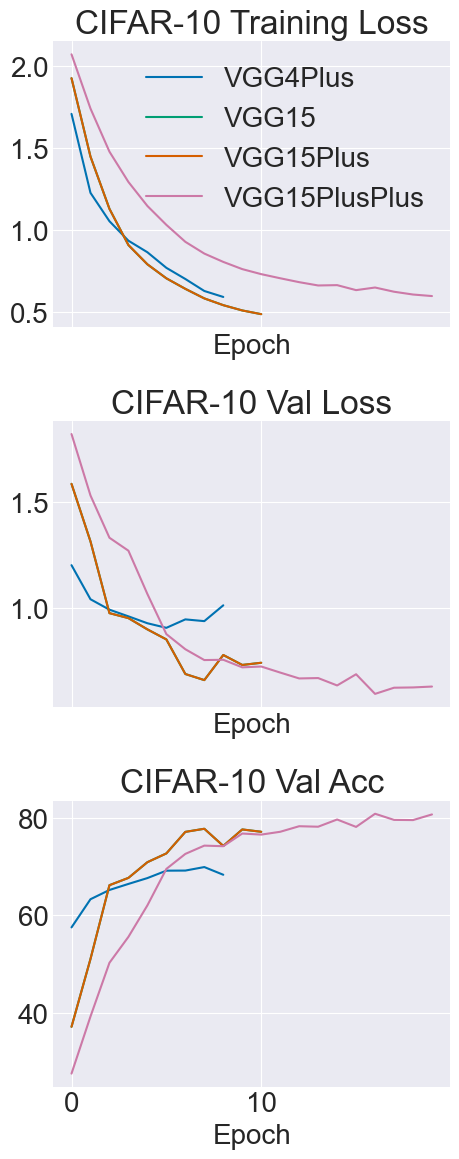

In [99]:
def plot_loss_acc_x3(train_losses, val_losses, val_accs, epochs,
                     net_names=['VGG15PlusPlus', 'VGG15', 'VGG15Plus', 'VGG4Plus']):
    '''Makes a 3x1 plot of the training losses, val losses, and val accs for the 4 nets.

    This complete function is provided to you. Feel free to modify if necessary.

    Parameters:
    -----------
    train_losses: Python list of list. len(train_losses)=4.
        List of the training loss histories of the 4 nets.
    val_losses: Python list of list. len(val_losses)=4.
        List of the val loss histories of the 4 nets.
    val_accs: Python list of list. len(val_accs)=4.
        List of the val accuracy histories of the 4 nets.
    epochs: Python list of int. len(epochs)=4.
        The number of epochs used to train each network.
    net_names: Python list of str. len(epochs)=4.
        The string name of the networks. The order must correspond to the order of the loss and acc lists.
    '''
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(5, 12))

    titles = ['CIFAR-10 Training Loss', 'CIFAR-10 Val Loss', 'CIFAR-10 Val Acc']
    xlabels = 3*['Epoch']
    data = [train_losses, val_losses, val_accs]

    for i in range(len(titles)):
        curr_hist = data[i]

        for n in range(len(net_names)):
            curr_data = np.copy(np.array(curr_hist[n]))

            if 'acc' in titles[i].lower():
                curr_data = 100*curr_data[:epochs[n]]

            axes[i].plot(curr_data, label=net_names[n])

        axes[i].set_xlabel(xlabels[i])
        # axes[i].set_ylabel(ylabels[i])
        axes[i].set_title(titles[i])

        if i == 0:
            axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_loss_acc_x3(train_losses, val_losses, val_accs, epochs, net_names)

### 9e. Questions

**Question 13** How does the runtime (per epoch) of the networks with batch normalization compare without it (e.g. `VGG15` vs. `VGG15Plus`)? 

**Answer 13:** The runtime (per epoch) with batch normalization was faster than without it.

## Task 10. Learning rate decay

The classification accuracy of the networks with batch normalization may seem a little underwhelming...but we can change that! A synergistic tool to potentially unlock improved classification accuracy is **learning rate decay.** We will adopt the simple approach of multiplicatively adjusting the learning rate. That is:

$$
\eta_{new} = d \times \eta_{curr}
$$

where $\eta$ is the learning rate and $d$ is a float between 0.0 and 1.0. This learning rate update does not occur on every epoch — it only gets applied when the validation loss stops improving for some number of epochs (i.e. the learning rate patience). This means we add and maintain an independent early stopping process dedicated to the learning rate.

Let's add this to the training workflow then revisit the performance of the networks with batch normalization.

In [107]:
from vgg_nets import VGG15PlusPlus, VGG15, VGG15Plus, VGG4Plus

### 10a. Add support for learning rate decay in `DeepNetwork`

Follow the procedure outlined in class add learning rate decay to the training workflow. Here is a brief summary:
1. Implement `update_lr(lr_decay_rate)` to multiplicatively adjust the optimizer's learning rate.
2. In `fit`, create a separate new empty list before the training loop to represent the rolling validation loss related to the learning rate decay process.
3. In `fit`, adjacent to where you check early stopping for training epochs, check "early stopping" for learning rate. If "early stopping" is triggered for the learning rate, decrease the learning rate. Only decrease the learning rate a preset number of times (`lr_max_decays`).

In [108]:
from layers import Dense
from network import DeepNetwork

#### Test: Learning rate decay

The following test trains a single layer softmax network on Iris. If everything is working as expected, you should see:
- learning rate decays from 0.1 to 0.05 during epoch 6.
- learning rate decays from 0.05 to 0.025 during epoch 25.
- learning rate decays from 0.025 to 0.0125 during epoch 39.
- learning rate decays from 0.0125 to 0.00625 during epoch 53.
- training ends after 65 epochs.

**Note:** If you do not get these exact results, that could be fine. What you are looking for is a drop in the learning rate when the val loss does not improve/decrease within a window of 3 epochs.

In [117]:
# Quickly make a mock network for testing
class SoftmaxNet(DeepNetwork):
    def __init__(self, input_feats_shape, C, reg=0):
        super().__init__(input_feats_shape, reg)
        self.output_layer = Dense('TestDense', units=C, activation='softmax', prev_layer_or_block=None)

    def __call__(self, x):
        return self.output_layer(x)

# Load in Iris train/validation sets
train_samps = tf.constant(np.load('data/iris/iris_train_samps.npy'), dtype=tf.float32)
train_labels = tf.constant(np.load('data/iris/iris_train_labels.npy'), dtype=tf.int32)
val_samps = tf.constant(np.load('data/iris/iris_val_samps.npy'), dtype=tf.float32)
val_labels = tf.constant(np.load('data/iris/iris_val_labels.npy'), dtype=tf.int32)

# Set some vars
C = 3
M = train_samps.shape[1]
mini_batch_sz = 25
lr = 1e-1
max_epochs = 5000
patience = 7
val_every = 1  # how often (in epochs) we check the val loss/acc/early stopping

# Create our test net
tf.random.set_seed(0)
slnet = SoftmaxNet((M,), C)
slnet.compile(lr=lr)

_, val_loss_hist, val_acc_hist, e = slnet.fit(train_samps, train_labels, val_samps, val_labels,
                                              batch_size=mini_batch_sz,
                                              max_epochs=max_epochs,
                                              patience=patience,
                                              val_every=val_every,
                                              lr_patience=3,
                                              lr_max_decays=4)

print(75*'-')
print(f'Iris test ended after {e} epochs with final val loss/acc of {val_loss_hist[-1]:.2f}/{val_acc_hist[-1]:.2f}')
print(75*'-')

---------------------------------------------------------------------------
Dense layer output(TestDense) shape: [1, 3]
---------------------------------------------------------------------------
Epoch 1: Training Loss = 1.1561, Validation Loss = 1.0572, Validation Accuracy = 0.6531
Epoch 1/5000 took 0.6381 seconds
Epoch 2: Training Loss = 0.8358, Validation Loss = 0.5779, Validation Accuracy = 0.6735
Epoch 2/5000 took 0.0172 seconds
Epoch 3: Training Loss = 0.6456, Validation Loss = 0.5150, Validation Accuracy = 0.6531
Epoch 3/5000 took 0.0151 seconds
Epoch 4: Training Loss = 0.5420, Validation Loss = 0.4582, Validation Accuracy = 0.6531
Epoch 4/5000 took 0.0296 seconds
Epoch 5: Training Loss = 0.4831, Validation Loss = 0.4446, Validation Accuracy = 0.6735
Epoch 5/5000 took 0.0178 seconds
Epoch 6: Training Loss = 0.3864, Validation Loss = 0.4211, Validation Accuracy = 0.6531
Epoch 6/5000 took 0.0162 seconds
Epoch 7: Training Loss = 0.4073, Validation Loss = 0.3679, Validation Accuracy

### 10b. Train VGG nets with batch normalization redux

Repeat the training session you performed in the previous task involving the "plus networks" on CIFAR-10:
- VGG4Plus
- VGG15
- VGG15Plus
- VGG15PlusPlus

Use default hyperparameters except:
- Use AdamW optimizer.
- Use He initialization
- Use a patience of `15`.
- Use a learning rate patience of 4.

After training each net, store/record:
1. the network's final test accuracy.
2. the history of training loss (averaged across mini-batches, so one per epoch).
3. the history of validation loss (checked every epoch).
4. the history of validation accuracy (checked every epoch).

**Notes:**
- Set random seed before creating each net for consistency.
- Use `tf.keras.backend.clear_session()` before creating each of the network to help prevent the memory used from growing.

Training these networks should take a few hours. Your VGG15PlusPlus network should achieve the best results and shatter your previous CIFAR-10 val/test accuracy record by a substantial margin.

In [118]:
net_names = ['VGG4Plus', 'VGG15', 'VGG15Plus', 'VGG15PlusPlus']
train_losses = []
val_losses = []
val_accs = []
epochs = []
accs = []

for net_name in net_names:
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    if net_name == 'VGG4Plus':
        model = VGG4Plus(10, (32, 32, 3))
    elif net_name == 'VGG15':
        model = VGG15(10, (32, 32, 3))
    elif net_name == 'VGG15Plus':
        model = VGG15Plus(10, (32, 32, 3))
    elif net_name == 'VGG15PlusPlus':
        model = VGG15PlusPlus(10, (32, 32, 3))

    model.compile(optimizer='adamw')
    train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, patience=15, lr_patience=4)
    test_acc = model.evaluate(x_test, y_test)[0]

    train_losses.append(train_loss_hist)
    val_losses.append(val_loss_hist)
    val_accs.append(val_acc_hist)
    epochs.append(num_epochs)
    accs.append(test_acc)

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 10]
Dropout layer output(dropout1) shape: [1, 128]
Dense layer output(dense1) shape: [1, 128]
Flatten layer output(flat) shape: [1, 16384]
MaxPool2D layer output(maxpool1) shape: [1, 16, 16, 64]
Conv2D layer output(conv2) shape: [1, 32, 32, 64]
Conv2D layer output(conv1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
Epoch 1: Training Loss = 1.7094, Validation Loss = 1.2019, Validation Accuracy = 0.5753
Epoch 1/10000 took 12.5524 seconds
Epoch 2: Training Loss = 1.2285, Validation Loss = 1.0419, Validation Accuracy = 0.6332
Epoch 2/10000 took 9.9109 seconds
Epoch 3: Training Loss = 1.0556, Validation Loss = 0.9930, Validation Accuracy = 0.6522
Epoch 3/10000 took 9.5954 seconds
Epoch 4: Training Loss = 0.9370, Validation Loss = 0.9617, Validation Accuracy = 0.6647
Epoch 4/10000 took 9.7166 seconds
Epoch 5: Training Loss = 0

Adapt the following code to plot your findings. `plot_loss_acc_x3` is defined in the previous task above.

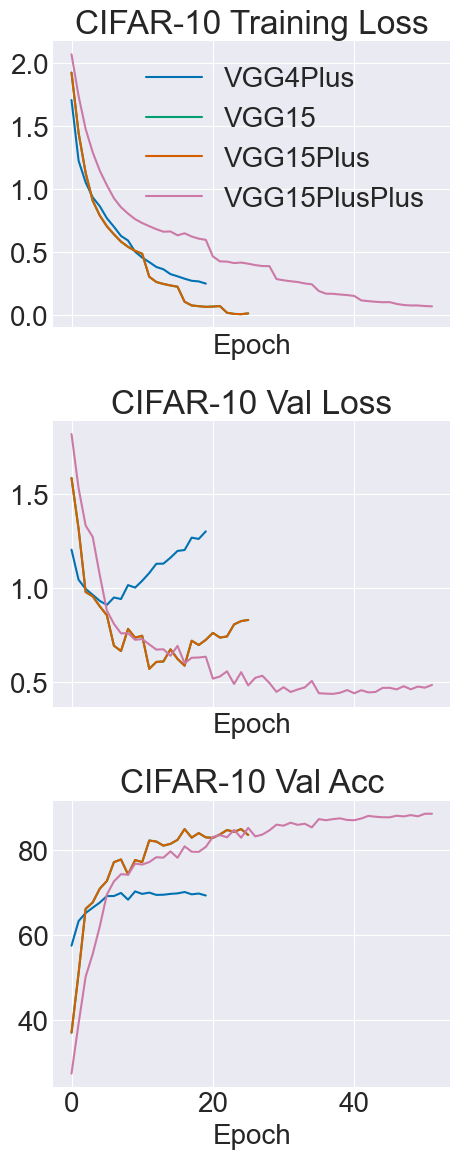

CIFAR-10 test accuracy:
VGG4Plus: 68.69%
VGG15: 83.12%
VGG15Plus: 83.12%
VGG15PlusPlus: 87.51%


In [119]:
plot_loss_acc_x3(train_losses, val_losses, val_accs, epochs, net_names)

print('CIFAR-10 test accuracy:')
for i in range(len(net_names)):
    print(f'{net_names[i]}: {100*accs[i]:.2f}%')

### 10c. Questions

**Question 14** What did the results of this experiment reveal about the relationship about network depth/size and classification accuracy? Please be specific.

**Question 15** Are there any downsides to the highest performing network (or is it just totally awesome :)?

**Answer 14:** 

**Answer 15:** 

## Extensions

### General guidelines

1. Never integrate extensions into your base project so that they change the expected behavior of core functions. If your extension changes the core design/behavior, no problem, duplicate your working base project and add features from there.
2. Check the rubric to keep in mind how extensions on this project will be graded.
3. While I may consult your code and "written log" of what you did, **I am grading your extensions based on what you present in your 3-5 min video.**
3. I suggest documenting your explorations in a "log" or "lab notebook" style (i.e. documenting your thought/progression/discovery/learning process). I'm not grading your writing, so you can keep it succinct. **Whatever is most useful to you to remember what you did.** 
4. I suggest taking a hypothesis driven approach. For example "I was curious about X so I explored Y. I found Z, which was not what I expected because..., so then tried A..."
5. Make plots to help showcase your results.
6. **More is not necessarily better.** Generally, a small number of "in-depth" extensions count for more than many "shallow" extensions.

### AI guidelines

You may use AI in mostly any capacity for extensions. However, keep in mind:
1. There is no need to use AI at all!
2. You are welcome to use AI as a tool (e.g. automate something that is tedious, help you get unstuck, etc.). However, you should be coding, you should be thinking, you should be writing, you should be creating. If you are spending most (or even close to most) of your time typing into a chatbot and copy-pasting, you have probably gone too far with AI use.
3. I don't find large volumes of AI generated code/text/plots to be particularly impressive and you risk losing my interest while grading. Remember: I'm grading your extensions based on your video presentation. **More is not necessarily better.**

### Video guidelines

1. Please try to keep your video to 5 minutes (*I have other projects to grade!*). If you turn in a longer video, I make no promise that I will watch more than 5 minutes.
2. Your screen should be shared as you show me what you did. A live video of your face should also appear somewhere on the screen (e.g. picture-in-picture overlay / split screen).
3. Your partner should join you for the video and take turns talking, but, if necessary, it is fine to have one team member present during the record the video.
4. Do not simply read text from your notebook, do not read from a prepared script. I am not grading how polished your video presentation is (see extension grading criteria on rubric). 
5. I am looking for original and creative explorations sparked by your curiosity/interest/passion in a topic. This should be apparent in your video.
6. Be natural,, don't feel the need to impress me with fancy language. If it is helpful, imagine that we are talking one-on-one about your extension. Tell me what you did :)

### Extension ideas

#### 1. Tune hyperparameters to achieve even better classification accuracy

Try to squeeze out a few extra percent test accuracy!

#### 2. Other image datasets

You now have a family of fast, high performing neural networks ranging in size. Apply them to another dataset of your choice. 

#### 3. AlexNet

Research the original AlexNet architecture and create a network that implements it. *You may have to ignore a few "hacks" Krizhevsky and colleagues had to perform — as pioneers, they were operating at the absolute limit of what GPUs of the day could do!*

#### 4. Add support for saving/loading network weights

A key limitation of your current deep learning library is that parameters that capture the learning in networks are completely reset/lost/wiped out when the notebook kernel is terminated. Add (and test!) support for saving network parameters to disk after (or periodically during) training. Add (and test!) support for loading network parameters back into the network from disk before training. 

Be careful to include the moving mean and standard deviation parameters in batch normalization layers otherwise the whole net will not work!

#### 5. VGG15 vs. VGG16

VGG16 has another Block of Dense layers compared to VGG15. Additionally, the VGG nets in the paper use 4096 dense units per Dense layer (vs 512 in your nets). Is deeper and more units better? Try it out!